*Irregular loss landscapes during the learning of long time-series data*
------

In [1]:
# ruff: noqa: E402, F722
%run _common.ipynb
%matplotlib inline
import torch
from torch import Tensor
import lightning
from jaxtyping import Float
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from node_homotopy.dynamics import LotkaVolterra, Lorenz3D
from node_homotopy.odesolve import odesolve
from node_homotopy.smoothing import CubicSplineSmoothing
from node_homotopy.synchronization import CouplingTerm, SynchronizedDynamics
from node_homotopy.training import VanillaTraining
from node_homotopy.experiments.lotka_volterra import (
    make_lotka_dataset,
    make_lotka_model,
)
from node_homotopy.landscape import (
    calculate_hessian_eigenbasis,
    calculate_hessian_eigspectrum,
    make_2d_landscape
)
from node_homotopy.plotting import plot_surface, plot_waterfall

## Loss landscapes in ODE parameter identification

### Shape of the loss landscape with increassing data length
First, we inspect the trajectories of the Lotka-Volterra and Lorenz3D systems change as their parameters are perturbed.

Note that the former displays periodic dynamics, whereas the latter is chaotic.

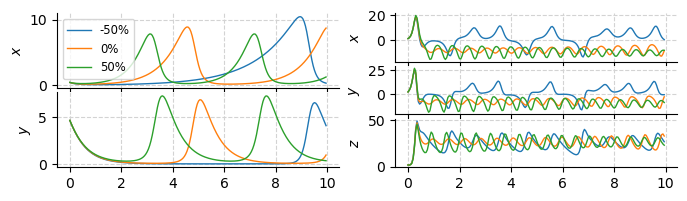

In [31]:
perturbations = (0.5, 1.0, 1.5)

t = torch.arange(0, 10, 0.05)

fig, axes_dict = plt.subplot_mosaic(
    """AC
    AC
    AD
    BD
    BE
    BE""",
    figsize=(8, 2),
    sharex=True,
)

for p in perturbations:
    # Create systems with perturbed parameters and solve
    lv = LotkaVolterra(a=1.3 * p)
    lz = Lorenz3D(b=(8 / 3) * p)
    with torch.no_grad():
        u_lv = odesolve(lv, torch.tensor([0.44249296, 4.6280594]).view(1, -1), t)
        u_lz = odesolve(lz, torch.tensor([1.2, 2.1, 1.7]).view(1, -1), t)

    # Plot each system in each column
    for i, (k, y_name) in enumerate(zip("AB", "xy")):
        axes_dict[k].plot(t, u_lv[0, i], label=f"{(p-1)*100:.0f}%")
        axes_dict[k].set_ylabel(f"${y_name}$")

    for i, (k, y_name) in enumerate(zip("CDE", "xyz")):
        axes_dict[k].plot(t, u_lz[0, i], label=f"{(p-1)*100:.0f}%")
        axes_dict[k].set_ylabel(f"${y_name}$")

    axes_dict["A"].legend(fontsize="small")

From the plotted results, we find that the chaotic Lorenz system results in a large variation of trajectories with respect to parameter change. The Lotka-Volterra system, on the other hand, demonstrates only changes in the amplitude and phase of its oscillations.

Now, we visualize a 1D slice of the loss landscape by varying one parameter along an equi-spaced grid, and calculating the mean-squared error between the perturbed trajectory and the original trajectory.

In [77]:
# Define a grid of perturbations - this is the x-axis values for the 1D loss landscape
perturb_grid = torch.linspace(0.5, 1.5, 50)


# Helper functions to repeatly solve the respective systems
def odesolve_lotka(perturb: float = 1.0) -> Float[Tensor, "1 2 100"]:
    u0_lotka = torch.tensor([0.44249296, 4.6280594]).view(1, -1)
    t = torch.arange(0, 10, 0.1)
    with torch.no_grad():
        u_lotka = odesolve(LotkaVolterra(a=1.3 * perturb), u0_lotka, t)
    return u_lotka


def odesolve_lorenz(perturb: float = 1.0) -> Float[Tensor, "1 3 100"]:
    u0_lorenz = torch.tensor([1.2, 2.1, 1.7]).view(1, -1)
    t = torch.arange(0, 10, 0.1)
    with torch.no_grad():
        u_lorenz = odesolve(Lorenz3D(b=(8 / 3) * perturb), u0_lorenz, t)
    return u_lorenz


# Actually perform the solve, and use tqdm to get progress bars
u_lv_ref = odesolve_lotka()
u_lv_perturbed = torch.cat([odesolve_lotka(p) for p in tqdm(perturb_grid)], dim=0)

u_lz_ref = odesolve_lorenz()
u_lz_perturbed = torch.cat([odesolve_lorenz(p) for p in tqdm(perturb_grid)], dim=0)

100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


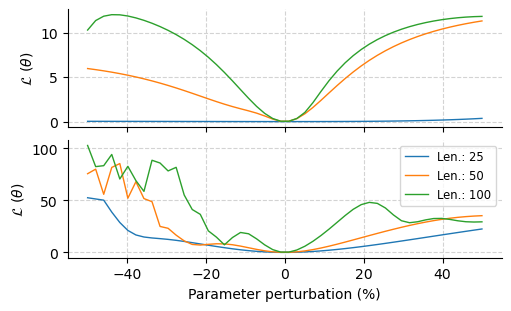

In [79]:
fig, axes = plt.subplots(2, 1, sharex=True)
data_lengths = (25, 50, 100)
perturb_grid_percent = (perturb_grid - 1) * 100

for data_len in data_lengths:
    # Compute mse for different length subsets of the trajectory and plot results
    # Lotka-Volterra system
    mse_values_lv = torch.mean(
        (u_lv_perturbed[..., :data_len] - u_lv_ref[..., :data_len]) ** 2, dim=(1, 2)
    )
    axes[0].plot(perturb_grid_percent, mse_values_lv, label=f"Len.: {data_len}")

    # Lorenz system
    mse_values_lz = torch.mean(
        (u_lz_perturbed[..., :data_len] - u_lz_ref[..., :data_len]) ** 2, dim=(1, 2)
    )
    axes[1].plot(perturb_grid_percent, mse_values_lz, label=f"Len.: {data_len}")

for ax in axes:
    ax.set_ylabel("$\mathcal{L}\ (\\theta)$")
axes[1].set_xlabel("Parameter perturbation (%)")
axes[1].legend(loc="upper right", fontsize="small")

The results show that for both systems, increased length of time-series data leads to a loss function that is more steep.

The chaotic Lorenz system exhibits a more pathological behavior with increased data length, due to the creation of  spurious local minimas.

### The effect of synchronization on the loss landscape

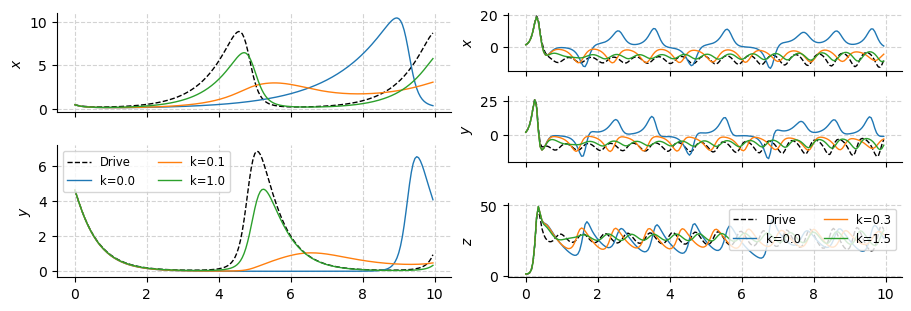

In [69]:
t = torch.arange(0, 10, 0.05)

fig, axes_dict = plt.subplot_mosaic(
    """AC
    AC
    AD
    BD
    BE
    BE""",
    figsize=(9, 3),
    sharex=True,
)

# Lotka-Voltera
# Set up the reference(drive) and the perturbed systems
lv_drive = LotkaVolterra(a=1.3)
lv_perturbed = LotkaVolterra(a=1.3 * 0.5)

with torch.no_grad():
    u_lv_drive = odesolve(
        lv_drive, torch.tensor([0.44249296, 4.6280594]).view(1, -1), t
    )
    lv_drive_interp = CubicSplineSmoothing(t, u_lv_drive)

# Calculate and plot the results
for i, (k, y_name) in enumerate(zip("AB", "xy")):
    # Plot the reference(drive) trajectory
    axes_dict[k].plot(t, u_lv_drive[0, i], "--", color="k", label="Drive")

    for coupling_strength in (0.0, 0.1, 1.0):
        # Create and solve synchronized dynamics
        lv_coupling_term = CouplingTerm(lv_drive_interp, coupling_strength)
        lv_response = SynchronizedDynamics(lv_perturbed, lv_coupling_term)

        with torch.no_grad():
            u_lv_resp = odesolve(
                lv_response, torch.tensor([0.44249296, 4.6280594]).view(1, -1), t
            )

        # Plot synchronized(response) trajectories
        axes_dict[k].plot(t, u_lv_resp[0, i], label=f"k={coupling_strength:.1f}")
        axes_dict[k].set_ylabel(f"${y_name}$")
axes_dict["B"].legend(loc="upper left", fontsize="small", ncols=2)


# Lorenz3D
# Set up the reference(drive) and the perturbed systems
lz_drive = Lorenz3D(b=8 / 3)
lz_perturbed = Lorenz3D(b=(8 / 3) * 0.5)

with torch.no_grad():
    u_lz_drive = odesolve(lz_drive, torch.tensor([1.2, 2.1, 1.7]).view(1, -1), t)
    lz_drive_interp = CubicSplineSmoothing(t, u_lz_drive)

# Calculate and plot the results
for i, (k, y_name) in enumerate(zip("CDE", "xyz")):
    # Plot the reference(drive) trajectory
    axes_dict[k].plot(t, u_lz_drive[0, i], "--", color="k", label="Drive")

    for coupling_strength in (0.0, 0.3, 1.5):
        # Create and solve synchronized dynamics
        lz_coupling_term = CouplingTerm(lz_drive_interp, coupling_strength)
        lz_response = SynchronizedDynamics(lz_perturbed, lz_coupling_term)

        with torch.no_grad():
            u_lz_resp = odesolve(
                lz_response, torch.tensor([1.2, 2.1, 1.7]).view(1, -1), t
            )

        # Plot synchronized(response) trajectories
        axes_dict[k].plot(t, u_lz_resp[0, i], label=f"k={coupling_strength:.1f}")
        axes_dict[k].set_ylabel(f"${y_name}$")
axes_dict["E"].legend(loc="upper right", fontsize="small", ncols=2)

As in the previous notebook, we find that increasing coupling strength causes the resulting response trajectory to approach the drive trajectory more and more.

In [74]:
# Define a grid of perturbations - this is the x-axis values for the 1D loss landscape
perturb_grid = torch.linspace(0.5, 1.5, 50)


# Helper functions to repeatly solve the respective systems
def odesolve_lotka_sync(
    perturb: float = 1.0, coupling_strength: float = 0.0
) -> Float[Tensor, "1 2 100"]:
    u0_lotka = torch.tensor([0.44249296, 4.6280594]).view(1, -1)
    t = torch.arange(0, 10, 0.1)
    with torch.no_grad():
        u_lotka_drive = odesolve(LotkaVolterra(a=1.3), u0_lotka, t)
        coupling_term_lotka = CouplingTerm(
            CubicSplineSmoothing(t, u_lotka_drive), coupling_strength
        )
        lotka_response = SynchronizedDynamics(
            LotkaVolterra(a=1.3 * perturb), coupling_term_lotka
        )
        u_lotka_resp = odesolve(lotka_response, u0_lotka, t)
    return u_lotka_resp


def odesolve_lorenz_sync(
    perturb: float = 1.0, coupling_strength: float = 0.0
) -> Float[Tensor, "1 2 100"]:
    u0_lorenz = torch.tensor([1.2, 2.1, 1.7]).view(1, -1)
    t = torch.arange(0, 10, 0.1)
    with torch.no_grad():
        u_lorenz_drive = odesolve(Lorenz3D(b=(8 / 3)), u0_lorenz, t)
        coupling_term_lorenz = CouplingTerm(
            CubicSplineSmoothing(t, u_lorenz_drive), coupling_strength
        )
        lorenz_response = SynchronizedDynamics(
            Lorenz3D(b=(8 / 3) * perturb), coupling_term_lorenz
        )
        u_lorenz_resp = odesolve(lorenz_response, u0_lorenz, t)
    return u_lorenz_resp


u_lv_ref = odesolve_lotka()
u_lz_ref = odesolve_lorenz()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Text(0.5, 0, 'Parameter perturbation (%)')

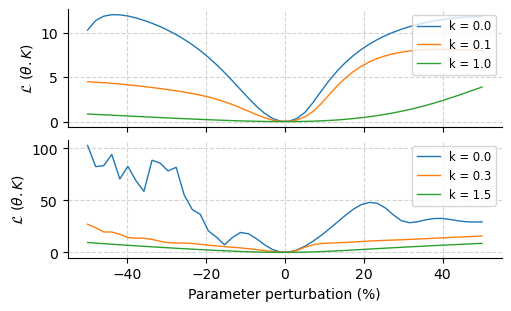

In [76]:
fig, axes = plt.subplots(2, 1, sharex=True)
perturb_grid_percent = (perturb_grid - 1) * 100

# Lotka-Volterra system
for coupling_strength in (0.0, 0.1, 1.0):
    # Compute mse for different coupling strengths and plot results
    u_lv_perturbed = torch.cat(
        [odesolve_lotka_sync(p, coupling_strength) for p in tqdm(perturb_grid)], dim=0
    )
    mse_values_lv = torch.mean((u_lv_perturbed - u_lv_ref) ** 2, dim=(1, 2))
    axes[0].plot(
        perturb_grid_percent, mse_values_lv, label=f"k = {coupling_strength:.1f}"
    )

for coupling_strength in (0.0, 0.3, 1.5):
    # Compute mse for different coupling strengths and plot results
    u_lz_perturbed = torch.cat(
        [odesolve_lorenz_sync(p, coupling_strength) for p in tqdm(perturb_grid)], dim=0
    )
    mse_values_lz = torch.mean((u_lz_perturbed - u_lz_ref) ** 2, dim=(1, 2))
    axes[1].plot(
        perturb_grid_percent, mse_values_lz, label=f"k = {coupling_strength:.1f}"
    )

for ax in axes:
    ax.legend(loc="upper right", fontsize="small")
    ax.set_ylabel("$\mathcal{L}\ (\\theta. K)$")
axes[1].set_xlabel("Parameter perturbation (%)")

## Loss landscapes in NeuralODE training

Now, we move onto inspecting the form of the loss landscape for NeuralODEs.
As these tend to be high-dimensional, we instead visualize a 2D slice of this landscape, spanned by the first two eigenvectors of the loss Hessian.

In [2]:
t_ends = (3.1, 5.1, 7.1, 9.1)
perturbs = np.linspace(-0.2, 0.2, 30)

RANDOM_SEED = 10
lightning.seed_everything(RANDOM_SEED)  # Fix random seed for reproducibility
neuralode = make_lotka_model("blackbox", nodes_per_layer=32)
training = VanillaTraining(neuralode, lr=5e-3)


# Define a convenience function to compute the landscape for a given dataset length
def make_hessian_landscape(
    t_end: float,
) -> Float[np.ndarray, "{len(perturbs)} {len(perturbs)}"]:
    dataset = make_lotka_dataset(t_end)
    eigenvecs = calculate_hessian_eigenbasis(training, dataset)
    loss_2d = make_2d_landscape(
        training, dataset, eigenvecs, (perturbs, perturbs), cuda=False
    )
    return loss_2d


# Note that the calculation takes some time - around 1 minute 30 seconds.
losses_dict = {t_end: make_hessian_landscape(t_end) for t_end in tqdm(t_ends)}

Seed set to 10
  0%|          | 0/4 [00:00<?, ?it/s]You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/jhko725/mambaforge/envs/homotopy/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1171.)
  Variable._execution_engine.run_bac

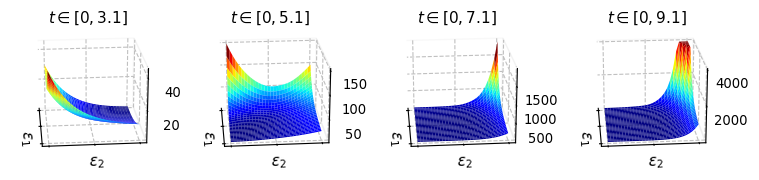

In [3]:
fig, axes = plt.subplots(
    1,
    4,
    figsize=(7.5, 4.5),
    sharex=True,
    sharey=True,
    subplot_kw={"projection": "3d"},
    constrained_layout=True,
)

for ax, (t_end, loss) in zip(axes.flat, losses_dict.items()):
    ax.view_init(azim=-5, elev=20)
    ax = plot_surface(ax, perturbs, perturbs, loss, z_clip_lim=(0, 4000), cmap="jet")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(labelsize=9.5)
    ax.xaxis.labelpad = -12
    ax.yaxis.labelpad = -12
    ax.zaxis.labelpad = 0
    ax.set_xlabel("$\epsilon_1$", fontsize=11)
    ax.set_ylabel("$\epsilon_2$", fontsize=11)
    ax.set_title(f"$t \in [0, {t_end}]$", fontsize=11, y=0.97)

Indeed, we see that the landscape becomes more and more pathological as the training data length increases.

### Inspecting the Hessian eigenvalue density spectrum

As the previous visualization is only a 2D slice of the full loss landscape, here we aim for a more comprehensive picture by calculating the eigenvalue density spectrum as a function of training data length.

In [4]:
RANDOM_SEED = 10
lightning.seed_everything(RANDOM_SEED)  # Fix random seed for reproducibility
neuralode = make_lotka_model("blackbox", nodes_per_layer=32)
training = VanillaTraining(neuralode, lr=5e-3)

log_densities, grids = [], []
t_ends = np.linspace(2.1, 10.1, 20)

# Also takes quite some time - about 2 minute 30 seconds
for t_end in tqdm(t_ends):
    dataset = make_lotka_dataset(t_end)
    g, d = calculate_hessian_eigspectrum(training, dataset, cuda=False)
    log_densities.append(np.log10(d))
    grids.append(g)

Seed set to 10
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:15<00:00,  6.75s/it]


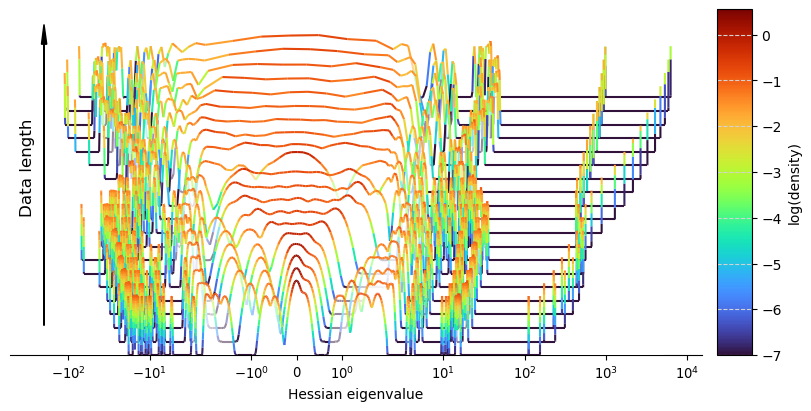

In [5]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4), constrained_layout=True)
ax = plot_waterfall(
    ax, t_ends, grids, log_densities, clabel="log(density)", cmap="turbo"
)
ax.tick_params(labelsize=9.5)
ax.set_xscale("symlog", base=10)
ax.set_xlabel("Hessian eigenvalue")
ax.grid(False)
ax.arrow(
    -200, -4.0, 0, 28.5, head_width=30.0, head_length=2.0, fill=True, facecolor="black"
)
ax.text(-400, 12, "Data length", fontsize="large", va="center", rotation="vertical")
ax.tick_params(labelsize=9.5)

We see that with increasing data length, the eigenvalue spectrum becomes wider, indicating that the loss landscape becomes more corrugated.
Large positive outlier peaks are also observed, which are though to be detrimental to the training process.